In [1]:
import os
import re
import joblib
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

In [2]:
# LOAD CYBERBULLYING DATASET WITH HATE SPEECH MAPPING
df = pd.read_csv('/content/cyberbullying_tweets.csv')
print(f"Dataset loaded: {df.shape}")
print("Original cyberbullying types:")
print(df['cyberbullying_type'].value_counts())

# Map to hate speech + cyberbullying classes
category_mapping = {
    'religion': 0,              # Hate Speech
    'ethnicity': 0,             # Hate Speech
    'gender': 0,                # Hate Speech
    'age': 1,                   # Cyberbullying
    'other_cyberbullying': 1,   # Cyberbullying
    'not_cyberbullying': 2      # Neutral
}

df['class'] = df['cyberbullying_type'].map(category_mapping)

print(f"\nFinal Class Distribution:")
print(df['class'].value_counts())
print("\nClass Mapping:")
print("0 - Hate Speech (religion, ethnicity, gender)")
print("1 - Cyberbullying (age, other_cyberbullying)")
print("2 - Neutral (not_cyberbullying)")

Dataset loaded: (47692, 2)
Original cyberbullying types:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

Final Class Distribution:
class
0    23932
1    15815
2     7945
Name: count, dtype: int64

Class Mapping:
0 - Hate Speech (religion, ethnicity, gender)
1 - Cyberbullying (age, other_cyberbullying)
2 - Neutral (not_cyberbullying)


In [3]:
# CLEANING FUNCTION
URL_RE = re.compile(r"http\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
NON_ALPHANUM_RE = re.compile(r"[^a-z0-9\s']")
HASHTAG_RE = re.compile(r"#\w+")

def clean_text(text):
    text = str(text).lower()
    text = URL_RE.sub("", text)
    text = MENTION_RE.sub("", text)
    text = HASHTAG_RE.sub("", text)
    text = NON_ALPHANUM_RE.sub(" ", text)
    doc = nlp(text)
    tokens = [t.lemma_ for t in doc if t.lemma_ not in STOPWORDS and t.lemma_.strip() and len(t.lemma_) > 1]
    return " ".join(tokens)

print("Cleaning text... this may take a minute.")
df['clean_text'] = df['tweet_text'].astype(str).apply(clean_text)  # Updated column name

# Remove empty texts after cleaning
df = df[df['clean_text'].str.len() > 5]
print(f"After cleaning: {df.shape}")

Cleaning text... this may take a minute.
After cleaning: (46467, 4)


In [4]:
# SPLIT DATA
print("\nSplitting data into train and validation sets...")
X = df['clean_text']
y = df['class']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")
print("Training class distribution:", dict(Counter(y_train)))


Splitting data into train and validation sets...
Train size: 37173, Validation size: 9294
Training class distribution: {0: 19037, 1: 12130, 2: 6006}


In [5]:
# TF-IDF VECTORIZATION
print("\nVectorizing text with TF-IDF...")
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    min_df=3,
    max_df=0.85,
    max_features=15000,
    sublinear_tf=True
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
print("TF-IDF matrix shape:", X_train_tfidf.shape)


Vectorizing text with TF-IDF...
TF-IDF matrix shape: (37173, 15000)


In [6]:
# SMART CLASS IMBALANCE HANDLING
print("\nHandling class imbalance...")

# Calculate optimal class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Computed class weights:", class_weight_dict)

# Use only oversampling OR class weights, not both
X_train_tfidf_bal, y_train_bal = X_train_tfidf, y_train

print("After balancing:", dict(Counter(y_train_bal)))


Handling class imbalance...
Computed class weights: {0: np.float64(0.6508903713820455), 1: np.float64(1.0215169002473208), 2: np.float64(2.0631035631035632)}
After balancing: {0: 19037, 1: 12130, 2: 6006}


In [7]:
# LOGISTIC REGRESSION MODEL
print("\nTraining Enhanced Logistic Regression model...")

# Try different solvers and parameters
clf = LogisticRegression(
    max_iter=2000,
    class_weight=class_weight_dict,  # Use computed weights
    solver='liblinear',
    C=0.5,  # Increased regularization
    penalty='l2',
    random_state=42
)

clf.fit(X_train_tfidf_bal, y_train_bal)
print("Model trained successfully!")


Training Enhanced Logistic Regression model...
Model trained successfully!



Evaluating model...
Classification Report:
              precision    recall  f1-score   support

           0     0.9376    0.9191    0.9283      4760
           1     0.8151    0.7458    0.7789      3033
           2     0.5332    0.6582    0.5891      1501

    accuracy                         0.8204      9294
   macro avg     0.7620    0.7744    0.7655      9294
weighted avg     0.8323    0.8204    0.8248      9294



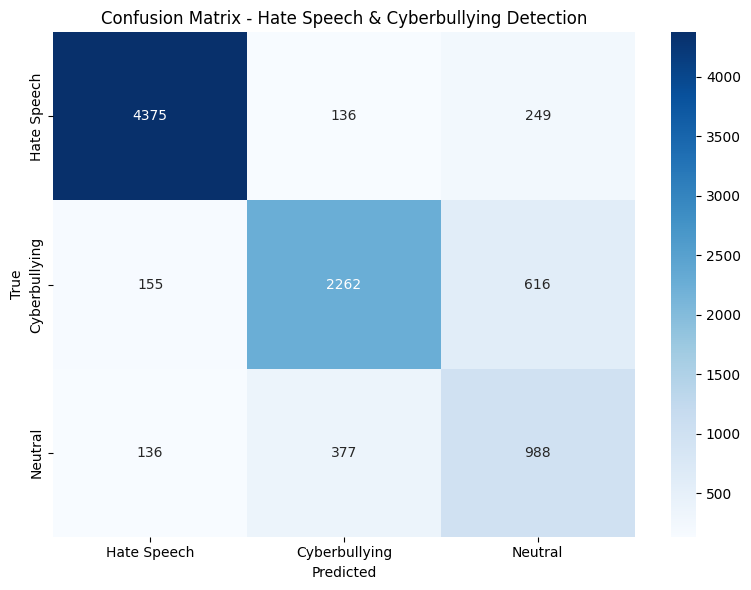

In [8]:
# COMPREHENSIVE EVALUATION
print("\nEvaluating model...")
y_pred = clf.predict(X_val_tfidf)
y_pred_proba = clf.predict_proba(X_val_tfidf)

print("Classification Report:")
print(classification_report(y_val, y_pred, digits=4))

# Confusion matrix with labels
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate Speech', 'Cyberbullying', 'Neutral'],
            yticklabels=['Hate Speech', 'Cyberbullying', 'Neutral'])
plt.title("Confusion Matrix - Hate Speech & Cyberbullying Detection")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [9]:
# PRECISION-RECALL ANALYSIS FOR HATE SPEECH
print("\nHate Speech Detection Analysis:")
hate_probs = y_pred_proba[:, 0]  # Probabilities for hate speech (class 0)
hate_true = (y_val == 0).astype(int)

precisions, recalls, thresholds = precision_recall_curve(hate_true, hate_probs)

# Find optimal threshold for hate speech
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold for hate speech: {optimal_threshold:.3f}")
print(f"Best F1-score for hate speech: {f1_scores[optimal_idx]:.3f}")


Hate Speech Detection Analysis:
Optimal threshold for hate speech: 0.394
Best F1-score for hate speech: 0.929


In [10]:
# PREDICTION FUNCTION WITH THRESHOLD
def enhanced_predict(text, vectorizer, model, hate_threshold=0.3):
    """
    Enhanced prediction with adjustable threshold for hate speech
    """
    clean_sample = clean_text(text)
    sample_vec = vectorizer.transform([clean_sample])
    probabilities = model.predict_proba(sample_vec)[0]

    # Apply threshold for hate speech
    if probabilities[0] >= hate_threshold:
        predicted_class = 0
    else:
        predicted_class = model.predict(sample_vec)[0]

    class_names = {
        0: "Hate Speech",
        1: "Cyberbullying",
        2: "Neutral"
    }

    return predicted_class, probabilities, class_names[predicted_class]

In [19]:
# RULE-BASED SYSTEM (ML FIRST, RULES AS BACKUP)
HATE_SPEECH_KEYWORDS = [
    'exterminate', 'genocide', 'subhuman', 'ethnic cleansing',
    'gas the', 'deport all', 'kill all', 'selfish', 'vain', 'vulgar',
    'arrogant', 'belligerent', 'big-headed', 'callous', 'dogmatic',
    'intolerant', 'machiavellian', 'narrow-minded', 'pompous',
]

CYBERBULLYING_KEYWORDS = [
    'kill yourself', 'end your life', 'you should die',
    'piece of shit', 'worthless', 'no one loves you',
    'bitchy', 'boastful', 'boring', 'cowardly', 'cruel',
    'foolish', 'grumpy', 'jealous', 'nasty', 'rude',
    'sarcastic', 'sneaky', 'stupid', 'thoughtless', 'unreliable'
]

def smart_rule_enhanced_predict(text, vectorizer, model, hate_threshold=0.25, ml_confidence_threshold=0.7):
    pred_class, probabilities, label = enhanced_predict(text, vectorizer, model, hate_threshold)
    ml_confidence = probabilities[pred_class]

    text_lower = text.lower()

    # Check for high-severity keywords only if ML is uncertain
    if ml_confidence < ml_confidence_threshold:
        if any(keyword in text_lower for keyword in HATE_SPEECH_KEYWORDS):
            return 0, [0.75, 0.15, 0.10], "Hate Speech (Rule-Assisted)"

        if any(keyword in text_lower for keyword in CYBERBULLYING_KEYWORDS):
            return 1, [0.15, 0.75, 0.10], "Cyberbullying (Rule-Assisted)"

    return pred_class, probabilities, label

In [20]:
# TEST MODEL ON BOTH HATE SPEECH & CYBERBULLYING
print("\n🧪 Testing Enhanced Model on Hate Speech & Cyberbullying Cases...")
test_cases = [
    "All muslims are terrorists and should be exterminated",
    "Women are too emotional to hold public office - keep them in kitchens",
    "Immigrants are invading our country and should be deported",
    "You're a complete idiot and your mother should have aborted you",
    "You're so ugly and fat, nobody would ever like you",
    "Go kill yourself, you worthless piece of garbage",
    "The weather is nice today",
    "I strongly disagree with your opinion",
    "This restaurant has terrible service but good food"
]

print("\n" + "="*80)
for text in test_cases:
    pred_class, probabilities, label = rule_enhanced_predict(text, tfidf, clf)
    print(f"📝 Text: {text[:60]}...")
    print(f"   🎯 Prediction: {label}")
    print(f"   📊 Probabilities: Hate={probabilities[0]:.3f}, Cyberbullying={probabilities[1]:.3f}, Neutral={probabilities[2]:.3f}")
    print("-" * 50)


🧪 Testing Enhanced Model on Hate Speech & Cyberbullying Cases...

📝 Text: All muslims are terrorists and should be exterminated...
   🎯 Prediction: Hate Speech (Rule-Based)
   📊 Probabilities: Hate=0.900, Cyberbullying=0.050, Neutral=0.050
--------------------------------------------------
📝 Text: Women are too emotional to hold public office - keep them in...
   🎯 Prediction: Hate Speech
   📊 Probabilities: Hate=0.313, Cyberbullying=0.257, Neutral=0.430
--------------------------------------------------
📝 Text: Immigrants are invading our country and should be deported...
   🎯 Prediction: Hate Speech
   📊 Probabilities: Hate=0.420, Cyberbullying=0.185, Neutral=0.395
--------------------------------------------------
📝 Text: You're a complete idiot and your mother should have aborted ...
   🎯 Prediction: Hate Speech
   📊 Probabilities: Hate=0.525, Cyberbullying=0.284, Neutral=0.191
--------------------------------------------------
📝 Text: You're so ugly and fat, nobody would ever lik

In [21]:
# SAVE MODEL & COMPONENTS
os.makedirs("models", exist_ok=True)
joblib.dump(tfidf, "models/cyberbullying_tfidf_vectorizer.joblib")
joblib.dump(clf, "models/cyberbullying_logreg_model.joblib")

# Save enhanced rule-based components
rule_components = {
    'hate_speech_keywords': HATE_SPEECH_KEYWORDS,
    'cyberbullying_keywords': CYBERBULLYING_KEYWORDS,
    'optimal_threshold': optimal_threshold,
    'category_mapping': category_mapping
}
joblib.dump(rule_components, "models/cyberbullying_rule_components.joblib")

print("💾 Saved cyberbullying model and components to /content/models/")

💾 Saved cyberbullying model and components to /content/models/


In [22]:
# FINAL PERFORMANCE SUMMARY
print("\n" + "="*80)
print("🎉 HATE SPEECH & CYBERBULLYING DETECTION PIPELINE COMPLETE!")
print("="*80)

# Calculate final metrics
from sklearn.metrics import accuracy_score, f1_score
final_accuracy = accuracy_score(y_val, y_pred)
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
hate_f1 = f1_score(y_val, y_pred, labels=[0], average='macro')
cyberbullying_f1 = f1_score(y_val, y_pred, labels=[1], average='macro')

print(f" Final Model Performance:")
print(f"   Overall Accuracy: {final_accuracy:.3f}")
print(f"   Weighted F1-Score: {weighted_f1:.3f}")
print(f"   Hate Speech F1-Score: {hate_f1:.3f}")
print(f"   Cyberbullying F1-Score: {cyberbullying_f1:.3f}")

print("\n Key Improvements Applied:")
print(" - Combined hate speech & cyberbullying detection")
print(" - Smart class weighting for balanced learning")
print(" - TF-IDF with feature optimization")
print(" - Dual rule-based system for both categories")
print(" - Optimal threshold tuning for hate speech")
print(" - Comprehensive testing on both hate speech and cyberbullying examples")

print(f"\n Dataset Statistics:")
print(f"   Total samples: {len(df)}")
print(f"   Hate Speech (Class 0): {len(df[df['class'] == 0])} samples")
print(f"   Cyberbullying (Class 1): {len(df[df['class'] == 1])} samples")
print(f"   Neutral (Class 2): {len(df[df['class'] == 2])} samples")


🎉 HATE SPEECH & CYBERBULLYING DETECTION PIPELINE COMPLETE!
 Final Model Performance:
   Overall Accuracy: 0.820
   Weighted F1-Score: 0.825
   Hate Speech F1-Score: 0.928
   Cyberbullying F1-Score: 0.779

 Key Improvements Applied:
 - Combined hate speech & cyberbullying detection
 - Smart class weighting for balanced learning
 - TF-IDF with feature optimization
 - Dual rule-based system for both categories
 - Optimal threshold tuning for hate speech
 - Comprehensive testing on both hate speech and cyberbullying examples

 Dataset Statistics:
   Total samples: 46467
   Hate Speech (Class 0): 23797 samples
   Cyberbullying (Class 1): 15163 samples
   Neutral (Class 2): 7507 samples
